torch로 mnist 생성모델 만들기

In [2]:
import torch
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
DEVICE


device(type='cuda')

In [3]:
import pandas as pd
import torch.nn as nn

# 생성모델

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 200), 
            nn.LeakyReLU(0.02), # 음수이면 기울기 0.02
            nn.LayerNorm(200), # 레이어에 대한 정규화
            nn.Linear(200, 784),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0 
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs.to(DEVICE))
    
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs.to(DEVICE))
        d_output = D.forward(g_output)
        loss = D.loss_function(d_output, targets.to(DEVICE))
        
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16, 8), alpha = 0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


In [4]:
G = torch.load('Data/result/final_G.h5')
G.to(DEVICE)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.02)
    (2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=200, out_features=784, bias=True)
    (4): Sigmoid()
  )
)

In [5]:
# 학습된 가중치 확인
print(G.model[3].weight[0][:10])
print(G.model[3].bias[:10])

tensor([ 0.3173, -0.0518,  0.2127,  0.2343,  0.2098, -0.0715,  0.3195,  0.0280,
         0.0007,  0.1920], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.3799, -0.3733, -0.4087, -0.4173, -0.4492, -0.4117, -0.4330, -0.4612,
        -0.3427, -0.4039], device='cuda:0', grad_fn=<SliceBackward0>)


In [6]:
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data


In [7]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'


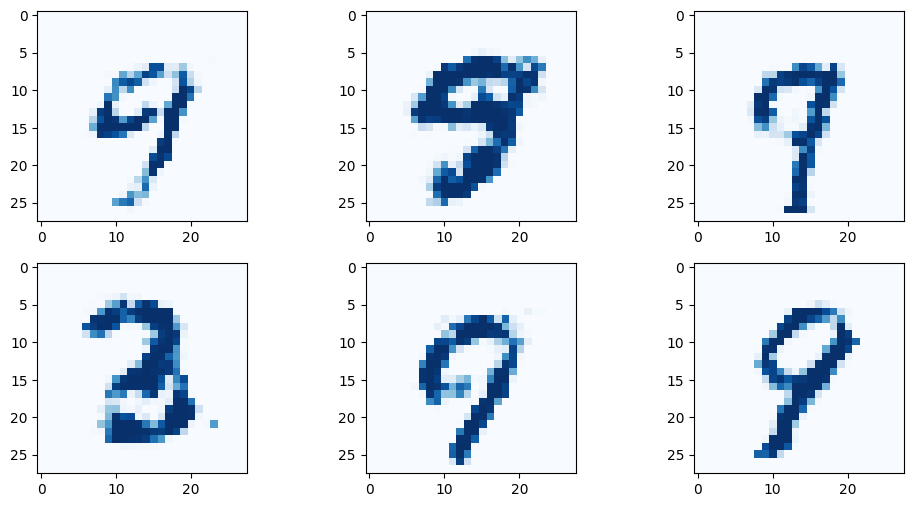

In [8]:

import matplotlib.pyplot as plt

count = 0
f, axarr = plt.subplots(2,3, figsize=(12,6))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.cpu().detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

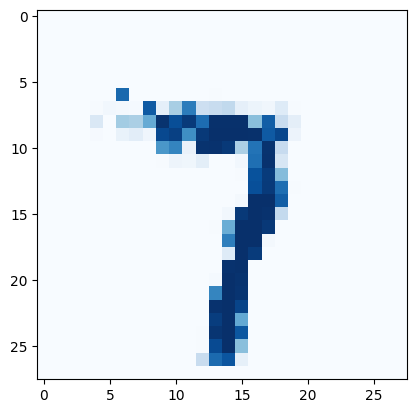

In [9]:
seed1 = generate_random_seed(100)
out1 = G.forward(seed1)
img1 = out1.cpu().detach().numpy().reshape(28,28)
plt.imshow(img1, cmap='Blues')
plt.show()

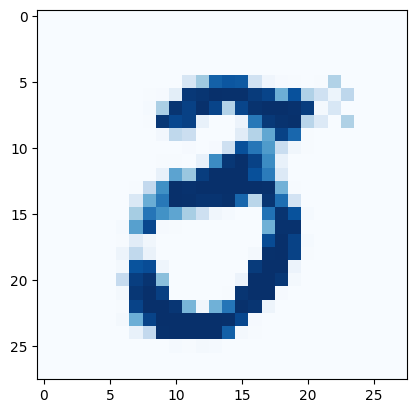

In [10]:
seed2 = generate_random_seed(100)
out2 = G.forward(seed2)
img2 = out2.cpu().detach().numpy().reshape(28,28)
plt.imshow(img2, cmap='Blues')
plt.show()

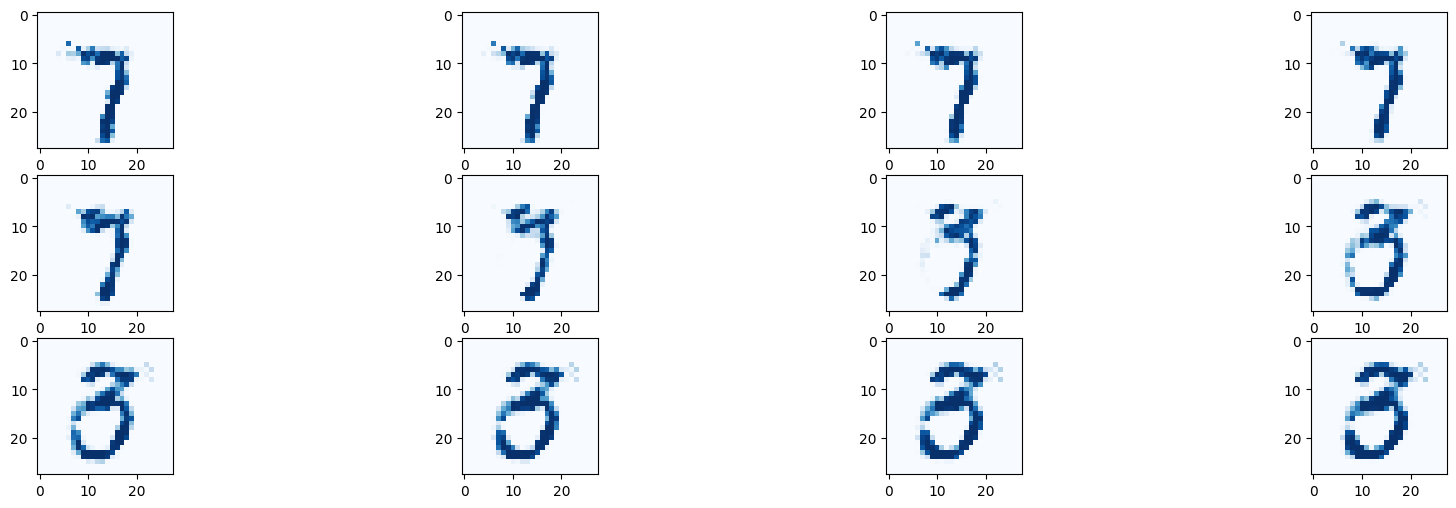

In [11]:
count = 0
f, axarr = plt.subplots(3,4, figsize=(21,6))
for i in range(3):
    for j in range(4):
        seed = seed1 + (seed2-seed1)/11 * count
        output = G.forward(seed)
        img = output.cpu().detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        count = count + 1
        pass
    pass

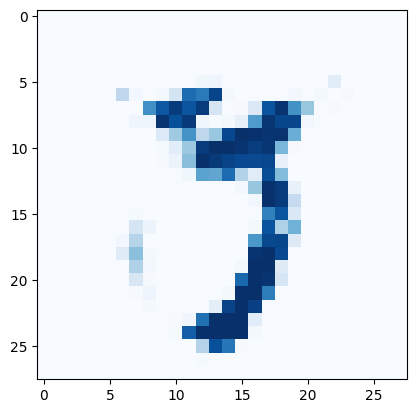

In [12]:
# sum of seeds
seed3 = seed1+seed2
out3 = G.forward(seed3)
img3 = out3.cpu().detach().numpy().reshape(28,28)
plt.imshow(img3, cmap='Blues')
plt.show()

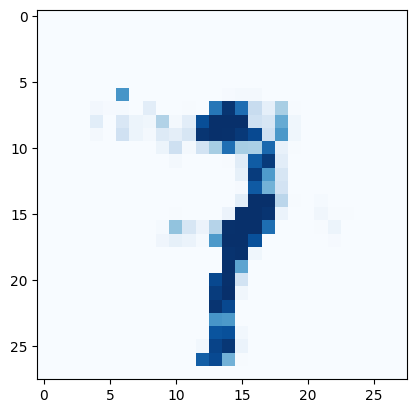

In [13]:
# difference of seeds
seed4 = seed1-seed2
out4 = G.forward(seed4)
img4 = out4.cpu().detach().numpy().reshape(28,28)
plt.imshow(img4, cmap='Blues')
plt.show()

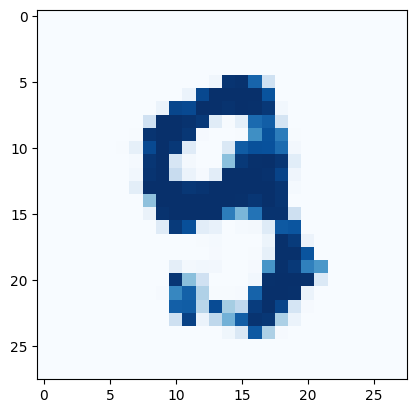

In [14]:
# difference of seeds
seed5 = seed1*seed2
out5 = G.forward(seed5)
img5 = out5.cpu().detach().numpy().reshape(28,28)
plt.imshow(img5, cmap='Blues')
plt.show()

In [15]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

epochs = 4

for epoch in range(epochs):
    print('epoch=', epoch +1)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        # 답    이미지픽셀           1

        # 판별모형 훈련 true
        D.train(image_data_tensor, torch.FloatTensor([1.0]))
                # 실제이미지            1

        # 판별모형 훈련 false
        D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
                        # 랜덤이미지                                0

        # 생성모델 훈련
        G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))
                        # 랜덤이미지                1
                        # 진짜에 가까운 모양으로 가중치가 업데이트됨
        

NameError: name 'Discriminator' is not defined

In [ ]:
D.plot_progress() # 판독오차

In [ ]:
G.plot_progress() #생성오차

In [ ]:
torch.save(G,'Data/result/final_G.h5')